In [1]:
import os
import helper_fxns as hf
import importlib
import sys
import nibabel as nib
import numpy as np
import pyelastix
from matplotlib import cm
import matplotlib.pyplot as plt
from skimage import measure
from skimage import data
from skimage.transform import rescale
from mpl_toolkits.mplot3d import Axes3D
from pylab import get_cmap
%matplotlib inline

In [18]:
importlib.reload(hf)

<module 'helper_fxns' from 'C:\\Users\\Clinton\\Documents\\spect-assessment\\helper_fxns.py'>

In [18]:
dcm_paths = {"ct": r"Z:\Isa\spect\E102337624\CT",
            "fused": r"Z:\Isa\spect\E102337624\Fused",
            "spect": r"Z:\Isa\spect\E102337624\SPECT",
            "fumri": r"Z:\Isa\fumri\E102406843\T1_AP",
            "blmri": r"Z:\Isa\blmri\E102155461\T1_AP"}

nii_paths = {"ct": r"Z:\Isa\3\ct_reg.nii",
            "fused": r"Z:\Isa\3\fused_reg.nii",
            "spect": r"Z:\Isa\3\spect_reg.nii",
            "fumri": r"Z:\Isa\3\fumri_reg.nii",
            "blmri": r"Z:\Isa\3\blmri_img.nii"}

mask_paths = {"liver": r"Z:\3\3.BL-segs\BL-Liver.ids",
            "tumor": r"Z:\3\3.BL-segs\BL-Tumor.ids",
            "necrosis": r"Z:\3\3.BL-segs\necrosis.ids",
            "viable-tumor": r"Z:\3\3.BL-segs\viable-tumor.ids"}

In [3]:
reg_params = pyelastix.get_default_params(type="AFFINE")

In [12]:
def get_spect_series(path):
    import convert_dicom
    import tempfile
    import shutil
    import dicom2nifti.settings as settings
    import dicom2nifti.common as common
    temp_directory = tempfile.mkdtemp()
    dicom_directory = os.path.join(temp_directory, 'dicom')
    shutil.copytree(path, dicom_directory)

    if convert_dicom.is_compressed(dicom_directory):
        if settings.gdcmconv_path is None and convert_dicom._which('gdcmconv') is None and convert_dicom._which('gdcmconv.exe') is None:
            raise ConversionError('GDCMCONV_NOT_FOUND')

        convert_dicom.logger.info('Decompressing dicom files in %s' % dicom_directory)
        for root, _, files in os.walk(dicom_directory):
            for dicom_file in files:
                if common.is_dicom_file(os.path.join(root, dicom_file)):
                    convert_dicom.decompress_dicom(os.path.join(root, dicom_file))

    dicom_input = common.read_dicom_directory(dicom_directory)
    
    rows = dicom_input[0][('0028', '0010')].value
    cols = dicom_input[0][('0028', '0011')].value
    ch = dicom_input[0][('0028', '0002')].value
    frames = dicom_input[0][('0028', '0008')].value
    bytelen = dicom_input[0][('0028', '0101')].value//8

    if len(dicom_input) == 1:
        ls = list(dicom_input[0][('7fe0', '0010')].value)
        img = [ls[x]+ls[x+1]*256 for x in range(0,len(ls),2)]
        img = np.reshape(img,(frames,rows,cols))
        canon_img = np.transpose(img, (2,1,0))[:,::-1,:]
    else:
        sl_list = []

        for sl in dicom_input:
            arr = sl[('7fe0', '0010')].value
            sl_list.append(np.reshape(list(arr),(rows,cols,ch)))
        img = np.array(sl_list)
        canon_img = np.transpose(img, (2,1,0,3))[:,::-1,:,:]

    return canon_img

In [ ]:
ct_img, ct_dims = hf.dcm_load(dcm_paths['ct'])
fumri_img, fumri_dims = hf.dcm_load(dcm_paths['fumri'])
blmri_img, blmri_dims = hf.dcm_load(blmri_path)

fused_img = get_spect_series(dcm_paths['fused'])
spect_img = get_spect_series(dcm_paths['spect'])

In [ ]:
#blmri_img = hf.ni_load(nii_paths["blmri"])

In [27]:
fumri_img_reg = hf.reg_imgs(moving=fumri_img, fixed=blmri_img, params=reg_params)
ct_img_reg = hf.reg_imgs(moving=ct_img, fixed=blmri_img, params=reg_params)

fused_img_reg = hf.reg_imgs(moving=fused_img[:,:,:,0], fixed=blmri_img, params=reg_params)
spect_img_reg = hf.reg_imgs(moving=spect_img, fixed=blmri_img, params=reg_params)

Found elastix version: 4.800 in 'c:\\program files\\elastix_v4.8\\elastix.exe'


In [ ]:
masked_spect = hf.apply_mask(spect_img_reg, )

In [33]:
def save_nii(img, dest):
    nii = nib.Nifti1Image(img, np.eye(4))
    nib.save(nii, dest)

In [34]:
save_nii(fumri_img_reg, nii_paths["fumri"])
save_nii(blmri_img, nii_paths["blmri"])
save_nii(ct_img_reg, nii_paths["ct"])
save_nii(fused_img_reg, nii_paths["fused"])
save_nii(spect_img_reg, nii_paths["spect"])

In [ ]:
plt.hist(spect_img)

In [ ]:
def get_dosage(df, spect_img_reg, mask):
    """Calculates dosage contained in mask by summing intensities in the registered spect_img.
    Assumes that intensity is linearly proportional to concentration."""

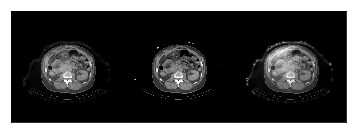

In [231]:
hf.plot_section_auto(fused_img)

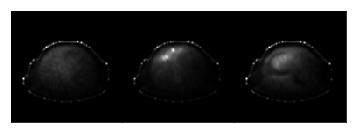

In [242]:
hf.plot_section_auto_1ch(spect_img)